# Your Prompt:
"Scenario: You're working at a retail chain analyzing inventory turnover. The store manager needs to understand stock movement patterns to optimize ordering. Data Structure: DataFrame product_id category stock_level last_restock_date sales_last_30_days supplier_lead_time unit_cost Task: Generate code to: Calculate inventory turnover rates. Identify slow-moving items. Predict potential stockouts. Create visualizations."





Inventory Metrics:
   product_id  inventory_turnover  stock_level  sales_last_30_days  \
0         101            0.400000           50                  20   
1         102            0.041667          120                   5   
2         103            0.833333           30                  25   
3         104            0.125000           80                  10   
4         105            0.020000          100                   2   

   daily_sales  days_remaining  potential_stockout  
0     0.666667            75.0               False  
1     0.166667           720.0               False  
2     0.833333            36.0               False  
3     0.333333           240.0               False  
4     0.066667          1500.0               False  

Slow-Moving Items:
   product_id     category  inventory_turnover  unit_cost
0         101  Electronics            0.400000      150.0
1         102     Clothing            0.041667       40.0
2         103  Electronics            0.833333  

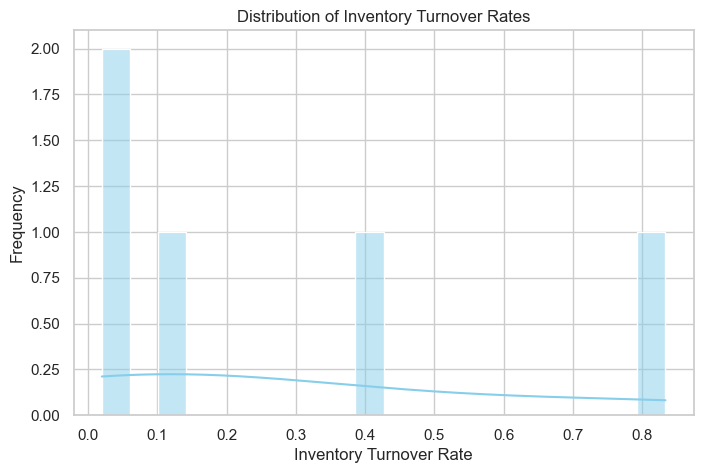

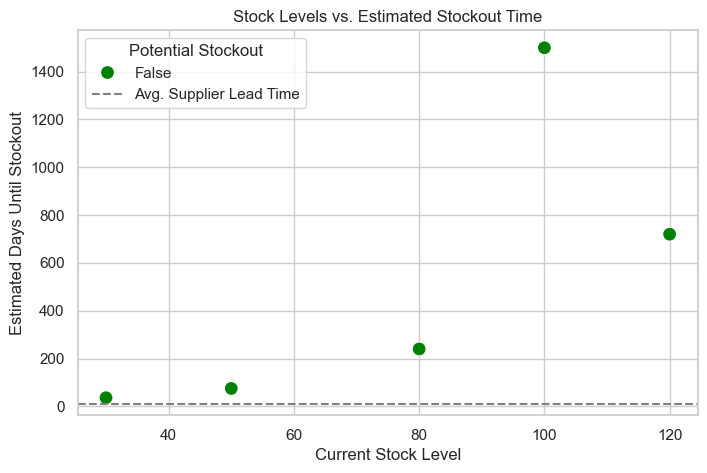

C:\Users\apcas\AppData\Local\Temp\ipykernel_29848\1760651226.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_unit_cost, x='category', y='unit_cost', palette='pastel')


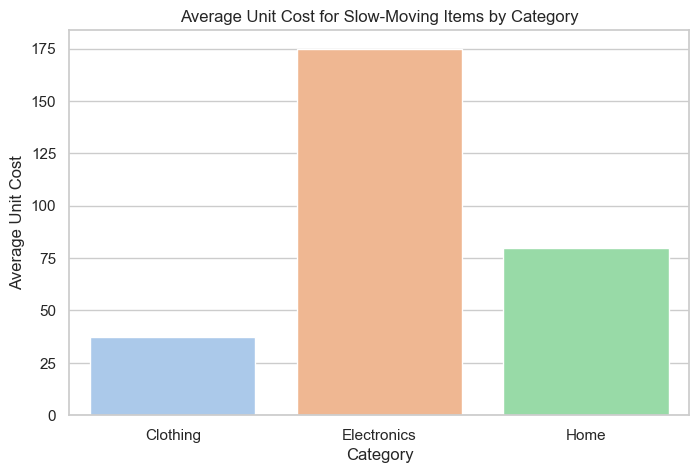

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def validate_inventory_data(df):
    """
    Validates that the DataFrame has all required columns and that
    numeric columns contain non-negative values.
    """
    required_cols = [
        'product_id', 'category', 'stock_level', 'last_restock_date',
        'sales_last_30_days', 'supplier_lead_time', 'unit_cost'
    ]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following required columns are missing: {missing_cols}")
    
    # Ensure numeric columns are numeric and non-negative
    numeric_cols = ['stock_level', 'sales_last_30_days', 'supplier_lead_time', 'unit_cost']
    for col in numeric_cols:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' must contain numeric data.")
        if (df[col] < 0).any():
            raise ValueError(f"Column '{col}' contains negative values, which are not allowed.")
    
    return df

def calculate_inventory_turnover(df):
    """
    Calculates the inventory turnover rate for each product.
    Turnover rate = sales_last_30_days / stock_level.
    Handles division by zero by replacing zero stock levels with NaN,
    then fills resulting NaN turnover values with 0.
    """
    df = df.copy()
    # Replace 0 stock levels with NaN to avoid division errors
    df['inventory_turnover'] = df['sales_last_30_days'] / df['stock_level'].replace(0, np.nan)
    df['inventory_turnover'] = df['inventory_turnover'].fillna(0)
    return df

def predict_stockouts(df):
    """
    Estimates how many days the current stock will last based on the last 30 days sales.
    daily_sales = sales_last_30_days / 30.
    days_remaining = stock_level / daily_sales.
    A product is flagged for potential stockout if days_remaining is less than supplier_lead_time.
    """
    df = df.copy()
    df['daily_sales'] = df['sales_last_30_days'] / 30.0
    df['days_remaining'] = df.apply(
        lambda row: row['stock_level'] / row['daily_sales'] if row['daily_sales'] > 0 else np.inf,
        axis=1
    )
    df['potential_stockout'] = df['days_remaining'] < df['supplier_lead_time']
    return df

def identify_slow_moving_items(df, turnover_threshold=1.0):
    """
    Identifies slow-moving items (default: inventory turnover rate below 1.0).
    """
    slow_movers = df[df['inventory_turnover'] < turnover_threshold].copy()
    return slow_movers

def create_visualizations(df, slow_movers):
    """
    Creates several visualizations:
      1. Histogram of Inventory Turnover Rates.
      2. Scatter Plot of Stock Level vs. Estimated Days Until Stockout.
      3. Bar Chart of Average Unit Cost for Slow-Moving Items by Category.
    """
    sns.set_theme(style="whitegrid")

    # Visualization 1: Distribution of Inventory Turnover Rates
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x='inventory_turnover', bins=20, kde=True, color='skyblue')
    plt.xlabel("Inventory Turnover Rate")
    plt.ylabel("Frequency")
    plt.title("Distribution of Inventory Turnover Rates")
    plt.show()

    # Visualization 2: Stock Level vs. Estimated Days Until Stockout
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df,
        x='stock_level',
        y='days_remaining',
        hue='potential_stockout',
        palette={True: 'red', False: 'green'},
        s=100
    )
    plt.xlabel("Current Stock Level")
    plt.ylabel("Estimated Days Until Stockout")
    plt.title("Stock Levels vs. Estimated Stockout Time")
    plt.axhline(
        y=np.mean(df['supplier_lead_time']),
        color='gray',
        linestyle='--',
        label='Avg. Supplier Lead Time'
    )
    plt.legend(title="Potential Stockout")
    plt.show()

    # Visualization 3: Average Unit Cost for Slow-Moving Items by Category
    if not slow_movers.empty:
        avg_unit_cost = slow_movers.groupby('category')['unit_cost'].mean().reset_index()
        plt.figure(figsize=(8, 5))
        sns.barplot(data=avg_unit_cost, x='category', y='unit_cost', palette='pastel')
        plt.xlabel("Category")
        plt.ylabel("Average Unit Cost")
        plt.title("Average Unit Cost for Slow-Moving Items by Category")
        plt.show()
    else:
        print("No slow-moving items to display.")

if __name__ == "__main__":
    # Sample Data: Replace this with actual data as needed
    sample_data = {
        'product_id': [101, 102, 103, 104, 105],
        'category': ['Electronics', 'Clothing', 'Electronics', 'Home', 'Clothing'],
        'stock_level': [50, 120, 30, 80, 100],
        'last_restock_date': pd.to_datetime(['2025-04-20', '2025-04-22', '2025-04-18', '2025-04-25', '2025-04-30']),
        'sales_last_30_days': [20, 5, 25, 10, 2],
        'supplier_lead_time': [7, 10, 7, 5, 10],
        'unit_cost': [150.0, 40.0, 200.0, 80.0, 35.0]
    }
    
    df = pd.DataFrame(sample_data)
    
    # Validate the DataFrame structure and values
    df = validate_inventory_data(df)
    
    # Calculate Inventory Turnover Rates
    df = calculate_inventory_turnover(df)
    
    # Predict potential stockouts based on sales trends
    df = predict_stockouts(df)
    
    # Identify slow-moving items (using a threshold inventory turnover rate < 1.0)
    slow_movers = identify_slow_moving_items(df, turnover_threshold=1.0)
    
    # Debug prints (optional)
    print("Inventory Metrics:")
    print(df[['product_id', 'inventory_turnover', 'stock_level', 'sales_last_30_days',
              'daily_sales', 'days_remaining', 'potential_stockout']])
    print("\nSlow-Moving Items:")
    print(slow_movers[['product_id', 'category', 'inventory_turnover', 'unit_cost']])
    
    # Create Summary Visualizations to Help the Manager
    create_visualizations(df, slow_movers)


# Follow-up Prompts:
Visualizations are giving an error.  Please ensure no warnings or errors are given

C:\Users\apcas\AppData\Local\Temp\ipykernel_29848\1760651226.py:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_unit_cost, x='category', y='unit_cost', palette='pastel')

Inventory Metrics:
   product_id  inventory_turnover  stock_level  sales_last_30_days  \
0         101            0.400000           50                  20   
1         102            0.041667          120                   5   
2         103            0.833333           30                  25   
3         104            0.125000           80                  10   
4         105            0.020000          100                   2   

   daily_sales  days_remaining  potential_stockout  
0     0.666667            75.0               False  
1     0.166667           720.0               False  
2     0.833333            36.0               False  
3     0.333333           240.0               False  
4     0.066667          1500.0               False  

Slow-Moving Items:
   product_id     category  inventory_turnover  unit_cost
0         101  Electronics            0.400000      150.0
1         102     Clothing            0.041667       40.0
2         103  Electronics            0.833333  

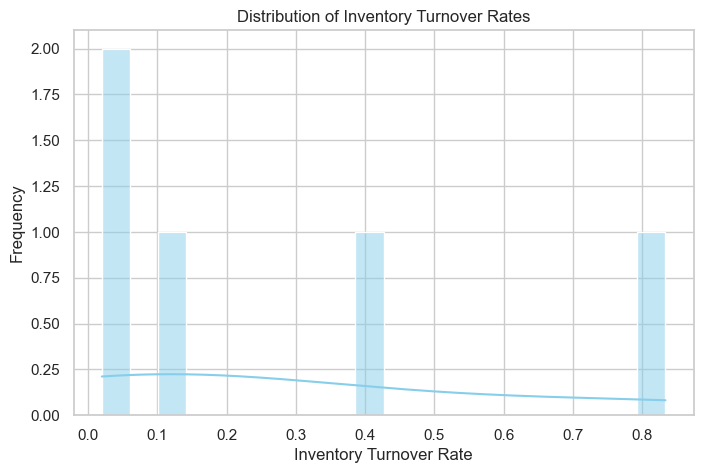

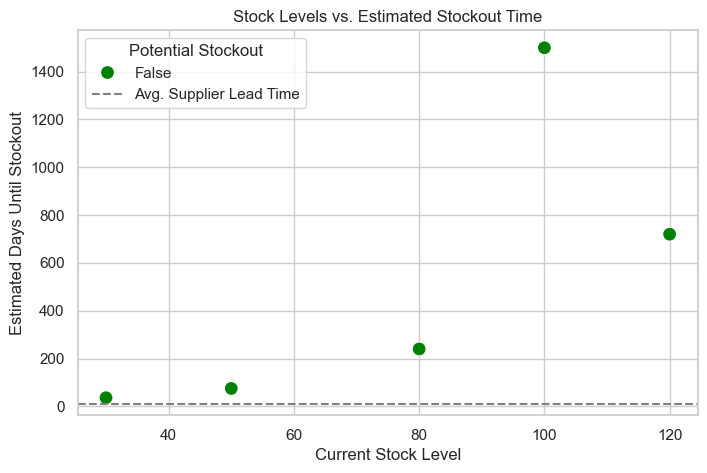

AttributeError: 'NoneType' object has no attribute 'remove'

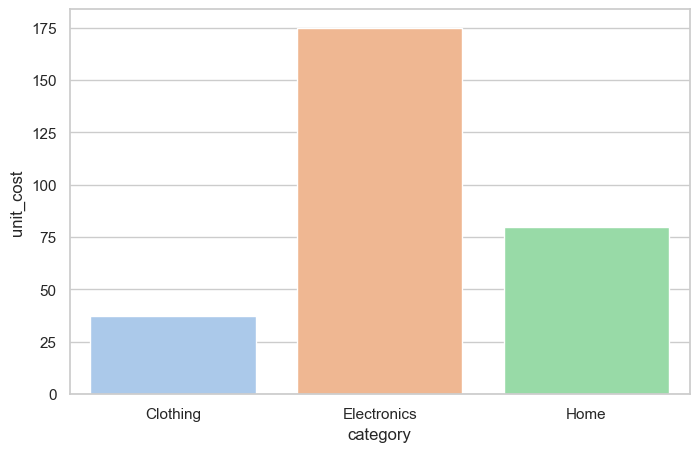

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def validate_inventory_data(df):
    """
    Validates that the DataFrame has all required columns and that
    numeric columns contain non-negative values.
    """
    required_cols = [
        'product_id', 'category', 'stock_level', 'last_restock_date',
        'sales_last_30_days', 'supplier_lead_time', 'unit_cost'
    ]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following required columns are missing: {missing_cols}")
    
    # Ensure numeric columns are numeric and non-negative
    numeric_cols = ['stock_level', 'sales_last_30_days', 'supplier_lead_time', 'unit_cost']
    for col in numeric_cols:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' must contain numeric data.")
        if (df[col] < 0).any():
            raise ValueError(f"Column '{col}' contains negative values, which are not allowed.")
    
    return df

def calculate_inventory_turnover(df):
    """
    Calculates inventory turnover rate for each product.
    Turnover rate = sales_last_30_days / stock_level.
    Guards against division by zero.
    """
    df = df.copy()
    # Replace 0 in stock_level with NaN to avoid division issues
    df['inventory_turnover'] = df['sales_last_30_days'] / df['stock_level'].replace(0, np.nan)
    df['inventory_turnover'] = df['inventory_turnover'].fillna(0)
    return df

def predict_stockouts(df):
    """
    Estimates how many days the current stock will last based on sales in the past 30 days.
    Flags a product for potential stockout if estimated days remaining is less than supplier lead time.
    """
    df = df.copy()
    df['daily_sales'] = df['sales_last_30_days'] / 30.0
    df['days_remaining'] = df.apply(
        lambda row: row['stock_level'] / row['daily_sales'] if row['daily_sales'] > 0 else np.inf,
        axis=1
    )
    df['potential_stockout'] = df['days_remaining'] < df['supplier_lead_time']
    return df

def identify_slow_moving_items(df, turnover_threshold=1.0):
    """
    Identifies slow-moving items with an inventory turnover rate below the threshold.
    """
    slow_movers = df[df['inventory_turnover'] < turnover_threshold].copy()
    return slow_movers

def create_visualizations(df, slow_movers):
    """
    Creates the following visualizations:
      1. Histogram of Inventory Turnover Rates.
      2. Scatter Plot of Stock Level vs. Estimated Days Until Stockout.
      3. Bar Chart of Average Unit Cost for Slow-Moving Items by Category.
    """
    sns.set_theme(style="whitegrid")

    # 1. Histogram of Inventory Turnover Rates
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x='inventory_turnover', bins=20, kde=True, color='skyblue')
    plt.xlabel("Inventory Turnover Rate")
    plt.ylabel("Frequency")
    plt.title("Distribution of Inventory Turnover Rates")
    plt.show()

    # 2. Scatter Plot: Stock Level vs. Estimated Days Until Stockout
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df,
        x='stock_level',
        y='days_remaining',
        hue='potential_stockout',
        palette={True: 'red', False: 'green'},
        s=100
    )
    plt.xlabel("Current Stock Level")
    plt.ylabel("Estimated Days Until Stockout")
    plt.title("Stock Levels vs. Estimated Stockout Time")
    plt.axhline(
        y=np.mean(df['supplier_lead_time']),
        color='gray',
        linestyle='--',
        label='Avg. Supplier Lead Time'
    )
    plt.legend(title="Potential Stockout")
    plt.show()

    # 3. Bar Chart: Average Unit Cost for Slow-Moving Items by Category
    if not slow_movers.empty:
        avg_unit_cost = slow_movers.groupby('category')['unit_cost'].mean().reset_index()
        plt.figure(figsize=(8, 5))
        # By assigning `hue='category'` (same as the x variable) and then removing the legend,
        # we satisfy the new requirement without triggering deprecation warnings.
        ax = sns.barplot(
            data=avg_unit_cost,
            x='category',
            y='unit_cost',
            hue='category',
            palette='pastel',
            dodge=False
        )
        ax.legend_.remove()
        plt.xlabel("Category")
        plt.ylabel("Average Unit Cost")
        plt.title("Average Unit Cost for Slow-Moving Items by Category")
        plt.show()
    else:
        print("No slow-moving items to display.")

if __name__ == "__main__":
    # Sample Data
    sample_data = {
        'product_id': [101, 102, 103, 104, 105],
        'category': ['Electronics', 'Clothing', 'Electronics', 'Home', 'Clothing'],
        'stock_level': [50, 120, 30, 80, 100],
        'last_restock_date': pd.to_datetime(['2025-04-20', '2025-04-22', '2025-04-18', '2025-04-25', '2025-04-30']),
        'sales_last_30_days': [20, 5, 25, 10, 2],
        'supplier_lead_time': [7, 10, 7, 5, 10],
        'unit_cost': [150.0, 40.0, 200.0, 80.0, 35.0]
    }
    
    df = pd.DataFrame(sample_data)
    
    # Validate the DataFrame structure and values
    df = validate_inventory_data(df)
    
    # Calculate Inventory Turnover Rates
    df = calculate_inventory_turnover(df)
    
    # Predict potential stockouts based on sales trends
    df = predict_stockouts(df)
    
    # Identify slow-moving items (using a threshold of inventory turnover < 1.0)
    slow_movers = identify_slow_moving_items(df, turnover_threshold=1.0)
    
    # Debug prints (optional)
    print("Inventory Metrics:")
    print(df[['product_id', 'inventory_turnover', 'stock_level', 'sales_last_30_days',
              'daily_sales', 'days_remaining', 'potential_stockout']])
    print("\nSlow-Moving Items:")
    print(slow_movers[['product_id', 'category', 'inventory_turnover', 'unit_cost']])
    
    # Create the visualizations
    create_visualizations(df, slow_movers)


Follow Up Prompt #2:

Fix this error:
AttributeError                            Traceback (most recent call last)
Cell In[14], line 157
    154 print(slow_movers[['product_id', 'category', 'inventory_turnover', 'unit_cost']])
    156 # Create the visualizations
--> 157 create_visualizations(df, slow_movers)

Cell In[14], line 115, in create_visualizations(df, slow_movers)
    105 # By assigning `hue='category'` (same as the x variable) and then removing the legend,
    106 # we satisfy the new requirement without triggering deprecation warnings.
    107 ax = sns.barplot(
    108     data=avg_unit_cost,
    109     x='category',
   (...)
    113     dodge=False
    114 )
--> 115 ax.legend_.remove()
    116 plt.xlabel("Category")
    117 plt.ylabel("Average Unit Cost")

AttributeError: 'NoneType' object has no attribute 'remove'

Inventory Metrics:
   product_id  inventory_turnover  stock_level  sales_last_30_days  \
0         101            0.400000           50                  20   
1         102            0.041667          120                   5   
2         103            0.833333           30                  25   
3         104            0.125000           80                  10   
4         105            0.020000          100                   2   

   daily_sales  days_remaining  potential_stockout  
0     0.666667            75.0               False  
1     0.166667           720.0               False  
2     0.833333            36.0               False  
3     0.333333           240.0               False  
4     0.066667          1500.0               False  

Slow-Moving Items:
   product_id     category  inventory_turnover  unit_cost
0         101  Electronics            0.400000      150.0
1         102     Clothing            0.041667       40.0
2         103  Electronics            0.833333  

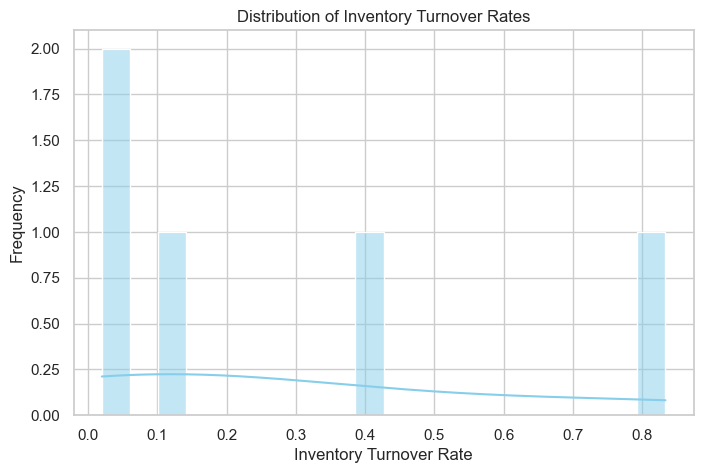

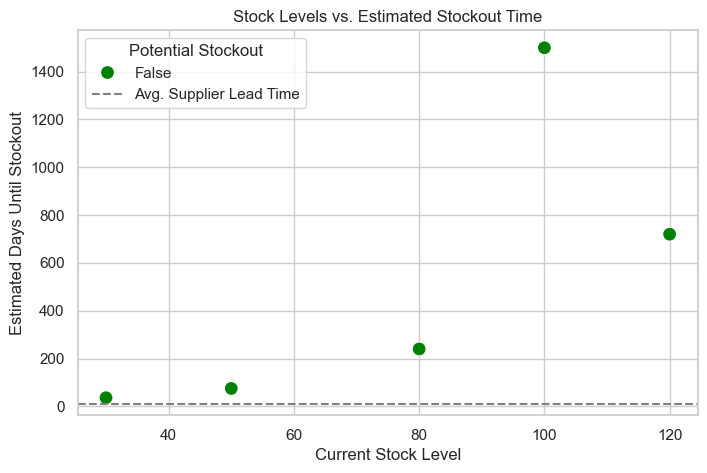

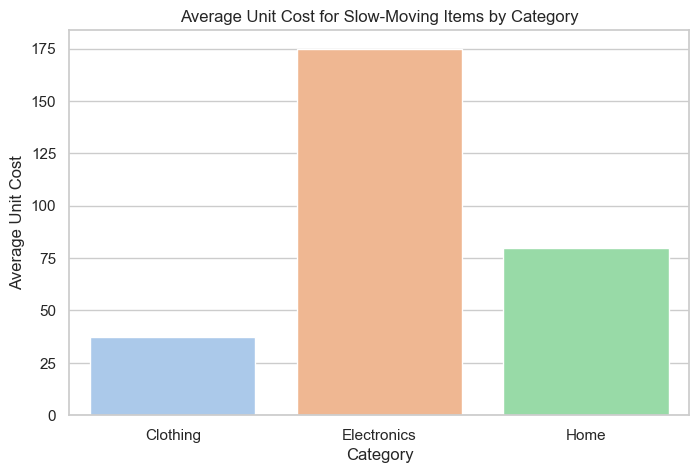

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def validate_inventory_data(df):
    """
    Validates that the DataFrame has all required columns and that
    numeric columns contain non-negative values.
    """
    required_cols = [
        'product_id', 'category', 'stock_level', 'last_restock_date',
        'sales_last_30_days', 'supplier_lead_time', 'unit_cost'
    ]
    missing_cols = [col for col in required_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following required columns are missing: {missing_cols}")
    
    # Ensure numeric columns are numeric and non-negative
    numeric_cols = ['stock_level', 'sales_last_30_days', 'supplier_lead_time', 'unit_cost']
    for col in numeric_cols:
        if not pd.api.types.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' must contain numeric data.")
        if (df[col] < 0).any():
            raise ValueError(f"Column '{col}' contains negative values, which are not allowed.")
    
    return df

def calculate_inventory_turnover(df):
    """
    Calculates inventory turnover rate for each product.
    Turnover rate = sales_last_30_days / stock_level.
    Guards against division by zero.
    """
    df = df.copy()
    # Replace 0 in stock_level with NaN to avoid division issues
    df['inventory_turnover'] = df['sales_last_30_days'] / df['stock_level'].replace(0, np.nan)
    df['inventory_turnover'] = df['inventory_turnover'].fillna(0)
    return df

def predict_stockouts(df):
    """
    Estimates how many days the current stock will last based on sales in the past 30 days.
    Flags a product for potential stockout if estimated days remaining is less than supplier lead time.
    """
    df = df.copy()
    df['daily_sales'] = df['sales_last_30_days'] / 30.0
    df['days_remaining'] = df.apply(
        lambda row: row['stock_level'] / row['daily_sales'] if row['daily_sales'] > 0 else np.inf,
        axis=1
    )
    df['potential_stockout'] = df['days_remaining'] < df['supplier_lead_time']
    return df

def identify_slow_moving_items(df, turnover_threshold=1.0):
    """
    Identifies slow-moving items with an inventory turnover rate below the threshold.
    """
    slow_movers = df[df['inventory_turnover'] < turnover_threshold].copy()
    return slow_movers

def create_visualizations(df, slow_movers):
    """
    Creates the following visualizations:
      1. Histogram of Inventory Turnover Rates.
      2. Scatter Plot of Stock Level vs. Estimated Days Until Stockout.
      3. Bar Chart of Average Unit Cost for Slow-Moving Items by Category.
    """
    sns.set_theme(style="whitegrid")

    # 1. Histogram of Inventory Turnover Rates
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x='inventory_turnover', bins=20, kde=True, color='skyblue')
    plt.xlabel("Inventory Turnover Rate")
    plt.ylabel("Frequency")
    plt.title("Distribution of Inventory Turnover Rates")
    plt.show()

    # 2. Scatter Plot: Stock Level vs. Estimated Days Until Stockout
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=df,
        x='stock_level',
        y='days_remaining',
        hue='potential_stockout',
        palette={True: 'red', False: 'green'},
        s=100
    )
    plt.xlabel("Current Stock Level")
    plt.ylabel("Estimated Days Until Stockout")
    plt.title("Stock Levels vs. Estimated Stockout Time")
    plt.axhline(
        y=np.mean(df['supplier_lead_time']),
        color='gray',
        linestyle='--',
        label='Avg. Supplier Lead Time'
    )
    plt.legend(title="Potential Stockout")
    plt.show()

    # 3. Bar Chart: Average Unit Cost for Slow-Moving Items by Category
    if not slow_movers.empty:
        avg_unit_cost = slow_movers.groupby('category')['unit_cost'].mean().reset_index()
        plt.figure(figsize=(8, 5))
        ax = sns.barplot(
            data=avg_unit_cost,
            x='category',
            y='unit_cost',
            hue='category',
            palette='pastel',
            dodge=False
        )
        # Remove legend only if present
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        plt.xlabel("Category")
        plt.ylabel("Average Unit Cost")
        plt.title("Average Unit Cost for Slow-Moving Items by Category")
        plt.show()
    else:
        print("No slow-moving items to display.")

if __name__ == "__main__":
    # Sample Data: Replace this with actual data as needed
    sample_data = {
        'product_id': [101, 102, 103, 104, 105],
        'category': ['Electronics', 'Clothing', 'Electronics', 'Home', 'Clothing'],
        'stock_level': [50, 120, 30, 80, 100],
        'last_restock_date': pd.to_datetime(['2025-04-20', '2025-04-22', '2025-04-18', '2025-04-25', '2025-04-30']),
        'sales_last_30_days': [20, 5, 25, 10, 2],
        'supplier_lead_time': [7, 10, 7, 5, 10],
        'unit_cost': [150.0, 40.0, 200.0, 80.0, 35.0]
    }
    
    df = pd.DataFrame(sample_data)
    
    # Validate the DataFrame structure and values
    df = validate_inventory_data(df)
    
    # Calculate Inventory Turnover Rates
    df = calculate_inventory_turnover(df)
    
    # Predict potential stockouts based on sales trends
    df = predict_stockouts(df)
    
    # Identify slow-moving items using a turnover threshold < 1.0
    slow_movers = identify_slow_moving_items(df, turnover_threshold=1.0)
    
    # Debug prints (optional)
    print("Inventory Metrics:")
    print(df[['product_id', 'inventory_turnover', 'stock_level', 'sales_last_30_days',
              'daily_sales', 'days_remaining', 'potential_stockout']])
    print("\nSlow-Moving Items:")
    print(slow_movers[['product_id', 'category', 'inventory_turnover', 'unit_cost']])
    
    # Create the visualizations
    create_visualizations(df, slow_movers)


Discussion Questions to Answer:

1) How did different prompts handle date calculations?
    After the initial prompt the data calculations remain unchanged.  During initial specification I requested all calculations to be in thier own function, including the creation of visuals.  The actual calculations the program created remained unchanged, however the visuals were updated as they were giving warning messages I wanted to disappear.


2) What visualization approaches were suggested?
    Three visuals were created by the copilot AI.  The distributions of inventory turnover rate shows on a daily basis what the average turnover rate is of the inventory vs how much total stock they have.  So the Y axis shows how many items are bought per day roughly, and the x axis shows what the turnover rate is.  Items with a high frequency of being bought as well as a high turnover rate, would be more likely to run out of inventory first.
    The scatter plot shows the current stock level of items vs how many days it is until it is estimated to be out of stock.  It also has a supplier lead time line to see how close it is needing to be ordered before potentially running out of stock.
    Also created a bar chart of average cost for slow moving items by category.  Shows what items are slow moving and their relative costs.  Possibly may be a reason for the slow moving of the items.

3) How was error handling implemented?
    Erorr handling was done in the code by checking for 0 values before doing calculations.  It would fill in the data with Nan before doing calculations if the data was 0 so that there would be no error for dividing by 0.